In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.utils as nn_utils
import math
import scipy
from tqdm import tqdm
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [3]:
import torch.nn as nn
import os
torch.manual_seed(42)


class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 L=1.0,
                 M=1):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.neurons, self.neurons)
            for _ in range(n_hidden_layers - 1)
        ])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()
        self.L = L
        self.M = M

    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        k = torch.arange(1, self.M + 1).to(device)
        out = torch.hstack([
            t.unsqueeze(1).to(device),
            torch.ones((t.shape[0],1)).to(device),
            torch.cos(w* torch.einsum('i,j->ji',k , x).to(device)),
            torch.sin(w* torch.einsum('i,j->ji',k , x).to(device))
        ])
        return out

    def forward(self, x):
        # The forward function performs the set of affine and non-linear
        # transformations defining the network (see equation above)
        x = x.to(device)
        x_encoded = self.input_encoding(x[:,0], x[:,1])
        x_encoded = self.activation(self.input_layer(x_encoded))
        for k, l in enumerate(self.hidden_layers):
            x_encoded = self.activation(l(x_encoded))
        return self.output_layer(x_encoded)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(
                    m
            ) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

In [4]:
class Pinns_Kuramoto:
    def __init__(self, n_int_t_, n_int_x_, n_sb_, n_tb_, t_0_, t_1_, init_cond_, L=1.0, M=1):
        self.n_int_t = n_int_t_
        self.n_int_x = n_int_x_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.t0 = t_0_
        self.t1 = t_1_
        self.lambda_f = 50
        self.init_cond = init_cond_
        
        
        # Causal Tools
        self.W = None
        ones_tensor = torch.ones((n_int_t, n_int_t))
        triu_tensor = torch.triu(ones_tensor, diagonal=1)
        self.M = triu_tensor.T.to(device)

        #Set constants
        self.alpha = 5
        self.beta = 0.5
        self.gamma = 0.005

        # Extrema of the solution domain 
        self.domain_extrema = torch.tensor([[self.t0,  self.t1],  [-1, 1]]) 

        # Number of space dimensions
        self.space_dimensions = 1


        # NN to Approximate Solution
        self.approximate_solution_flame = NeuralNet(input_dimension=2*M+2, output_dimension=1,
                                              n_hidden_layers=5,
                                              neurons=120,
                                              regularization_param=0.01,
                                              regularization_exp=2.,
                                              retrain_seed=42, L=2.0, M=1).to(device)
      # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0], scramble = True)
        self.soboleng_int = torch.quasirandom.SobolEngine(dimension=1, scramble = True)

      # Training Sets S_tb, S_sb, S_int as Torch Dataloader
        self.training_set_tb, self.training_set_sb, self.training_set_int, = self.assemble_datasets()

    ################################################################################################

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def convert_time(self, tens):
        #assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[0, 1] - self.domain_extrema[0, 0]) + self.domain_extrema[0, 0]

    def convert_space(self, tens):
        #assert (tens.shape[] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[1, 1] - self.domain_extrema[1, 0]) + self.domain_extrema[1, 0]

    def initial_conditions(self, x):
        if self.init_cond is None:
            return - torch.sin(math.pi * x)
        else:
            return self.init_cond.detach()

    def create_left_sb_mask(self, inp_sb):
        left_sb_mask = (inp_sb[:, 1] == -1)
        return left_sb_mask

    def create_right_sb_mask(self, inp_sb):
        right_sb_mask = (inp_sb[:, 1] == 1)
        return right_sb_mask

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        
        input_tb_x = torch.linspace(x0, xL, self.n_tb)
        input_tb_t = torch.full_like(input_tb_x, self.t0)
        input_tb = torch.cat((input_tb_t.unsqueeze(1),input_tb_x.unsqueeze(1)), dim=1)
        output_tb = self.initial_conditions(input_tb[:, 1]).reshape(-1, 1)
        
        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        """
        t0 = self.domain_extrema[0, 0]
        t1 = self.domain_extrema[0, 1]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        
        inpt = torch.linspace(t0 + self.epsilon, t1 - self.epsilon, self.n_int_t)
        inpx = torch.linspace(x0 + self.epsilon, xL - self.epsilon, self.n_int_x)
        tt, xx = torch.meshgrid(inpt, inpx)

        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        """
        
        input_time = self.convert(self.soboleng.draw(self.n_int_t))
        inpt = input_time[:, 0].unique()
        inpt = torch.linspace(self.t0,self.t1,self.n_int_t)
        inpx = self.convert_space(self.soboleng_int.draw(self.n_int_x)).squeeze(1)
        tt, xx = torch.meshgrid(inpt, inpx)

        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))

        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_int, output_int = self.add_interior_points()  # S_int

        input_tb, output_tb = input_tb.to(device), output_tb.to(device)
        input_sb, output_sb = input_sb.to(device), output_sb.to(device)
        input_int, output_int = input_int.to(device), output_int.to(device)

        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False) #2 * self.space_dimensions * self.n_sb
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int_t * self.n_int_x, shuffle=False)

        return training_set_tb, training_set_sb, training_set_int


################################################################################################

    #   Compute Temporal Boundary Residuals
    def compute_temporal_boundary_residual(self, input_tb, output_tb):
        assert(torch.all(input_tb[:,0] == self.t0))
        u = self.approximate_solution_flame(input_tb).reshape(-1,)
        temp_tb_train = output_tb.reshape(-1,)

        assert(u.shape == temp_tb_train.shape)
        residual_tb = temp_tb_train - u

        return residual_tb.reshape(-1,)
    """
    #   Compute Spatial Boundary Residuals
    def compute_spatial_boundary_residual(self, input_sb, output_sb):
        u = self.approximate_solution_flame(input_sb).reshape(-1,)

        mask_L = self.create_left_sb_mask(input_sb)
        mask_R = self.create_right_sb_mask(input_sb)
        assert(u[mask_L].shape == u[mask_R].shape)

        residual_sb = u[mask_L] - u[mask_R]

        return residual_sb.reshape(-1,)
    """
    #   Compute Interior Residuals
    def compute_interior_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution_flame(input_int).reshape(-1,)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xxx = torch.autograd.grad(grad_u_xx.sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xxxx = torch.autograd.grad(grad_u_xxx.sum(), input_int, create_graph=True)[0][:, 1]

        assert(u.shape == grad_u_t.shape and u.shape == grad_u_x.shape and u.shape == grad_u_xx.shape )

        residual_int = grad_u_t + self.alpha*u*grad_u_x + self.beta*grad_u_xx + self.gamma*grad_u_xxxx
        
        #return residual_int.reshape(-1,)
        return residual_int.reshape(self.n_int_t, self.n_int_x)


    #   Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, verbose=True):
        
        # Temporal Boundary Residuals
        r_tb = self.compute_temporal_boundary_residual(inp_train_tb, T_train_tb)

        # Interior Residuals
        r_int = self.compute_interior_residual(inp_train_int)

        loss_tb = torch.mean(abs(r_tb) ** 2)
        L_t = torch.mean(r_int**2, axis=1)
        self.W = torch.exp(- self.tol * torch.matmul(self.M, L_t)).detach().to(device)
        loss_int = torch.mean(self.W * L_t)

        loss = torch.log10(self.lambda_f * loss_tb  + loss_int)
        
        return loss, torch.log10(loss_tb), torch.log10(loss_int)
    
    ################################################################################################
     
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()
        # Loop over epochs
        pbar = trange(num_epochs)
        for epoch in pbar:
            for j, ((inp_train_tb, u_train_tb), (inp_train_sb, u_train_sb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_tb, self.training_set_sb, self.training_set_int)):
                optimizer.zero_grad()
                loss, loss_f, loss_i = self.compute_loss(inp_train_tb, u_train_tb, inp_train_sb, u_train_sb, inp_train_int, u_train_int, verbose=True)
                loss.backward()
                #nn_utils.clip_grad_norm_(self.approximate_solution_fluid.parameters(), max_norm=1.0)

                history.append(loss.item())
                optimizer.step()
            
            scheduler.step()
            pbar.set_description(f"Tol ={self.tol}, LR = {round(optimizer.param_groups[0]['lr'], 6)}, Loss = {round(loss.item(),4)}, Function = {round(loss_f.item(),4)}, PDE = {round(loss_i.item(),4)}")
            if epoch % 50 == 0:
                if self.W[-1] > 0.99:
                    break
                
        print('Final Loss: ', history[-1])

        return history


In [5]:
n_int_t = 64
n_int_x = 128
n_sb = 512
n_tb = 1024

C:\Users\matth\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Tol =0.01, LR = 0.000122, Loss = -0.5298, Function = -3.1962, PDE = -0.5793: 100%|█| 2000/2000 [12:16<00:00,  2.72it/s]


Final Loss:  -0.5297846794128418


Tol =0.1, LR = 1.5e-05, Loss = -2.0135, Function = -4.8767, PDE = -2.0443: 100%|███| 2000/2000 [12:30<00:00,  2.66it/s]


Final Loss:  -2.013463020324707


Tol =10.0, LR = 2e-06, Loss = -2.7718, Function = -6.5998, PDE = -2.7751: 100%|████| 2000/2000 [11:34<00:00,  2.88it/s]


Final Loss:  -2.7718427181243896


Tol =0.01, LR = 0.000122, Loss = -0.2583, Function = -2.7227, PDE = -0.3401: 100%|█| 2000/2000 [12:17<00:00,  2.71it/s]


Final Loss:  -0.2583208978176117


Tol =0.1, LR = 1.5e-05, Loss = -0.9998, Function = -2.9916, PDE = -1.3091: 100%|███| 2000/2000 [12:15<00:00,  2.72it/s]


Final Loss:  -0.9997522830963135


Tol =10.0, LR = 2e-06, Loss = -2.5356, Function = -5.1834, PDE = -2.5874: 100%|████| 2000/2000 [12:27<00:00,  2.67it/s]


Final Loss:  -2.5355589389801025


Tol =0.01, LR = 0.000122, Loss = 0.0124, Function = -1.8122, PDE = -0.5878: 100%|██| 2000/2000 [09:41<00:00,  3.44it/s]


Final Loss:  0.012368801049888134


Tol =0.1, LR = 1.5e-05, Loss = -0.278, Function = -2.1079, PDE = -0.8627: 100%|████| 2000/2000 [09:30<00:00,  3.51it/s]


Final Loss:  -0.2780083119869232


Tol =10.0, LR = 2e-06, Loss = -1.3369, Function = -3.2089, PDE = -1.8203: 100%|████| 2000/2000 [11:59<00:00,  2.78it/s]


Final Loss:  -1.3369452953338623


Tol =0.01, LR = 0.000122, Loss = 0.087, Function = -1.6865, PDE = -0.7152: 100%|███| 2000/2000 [13:15<00:00,  2.51it/s]


Final Loss:  0.08701460063457489


Tol =0.1, LR = 1.5e-05, Loss = -0.1525, Function = -1.9698, PDE = -0.775: 100%|████| 2000/2000 [10:29<00:00,  3.17it/s]


Final Loss:  -0.1524944305419922


Tol =10.0, LR = 2e-06, Loss = -0.398, Function = -2.2495, PDE = -0.9265: 100%|█████| 2000/2000 [09:28<00:00,  3.52it/s]


Final Loss:  -0.3980174660682678


Tol =0.01, LR = 0.000122, Loss = 0.1331, Function = -1.763, PDE = -0.3047: 100%|███| 2000/2000 [09:21<00:00,  3.56it/s]


Final Loss:  0.13314451277256012


Tol =0.1, LR = 1.5e-05, Loss = -0.6068, Function = -2.7952, PDE = -0.7769: 100%|███| 2000/2000 [10:11<00:00,  3.27it/s]


Final Loss:  -0.6068381667137146


Tol =10.0, LR = 2e-06, Loss = -1.7659, Function = -3.5325, PDE = -2.6066: 100%|████| 2000/2000 [12:07<00:00,  2.75it/s]


Final Loss:  -1.7659002542495728


Tol =0.01, LR = 0.001, Loss = 2.077, Function = 0.3597, PDE = 0.6921: 100%|██████████████| 1/1 [00:00<00:00,  3.37it/s]


Final Loss:  2.076953411102295


Tol =0.1, LR = 0.001, Loss = 2.1396, Function = 0.4308, PDE = 0.4898: 100%|██████████████| 1/1 [00:00<00:00,  3.71it/s]


Final Loss:  2.139646291732788


Tol =10.0, LR = 0.001, Loss = 1.997, Function = 0.2874, PDE = 0.3772: 100%|██████████████| 1/1 [00:00<00:00,  2.99it/s]


Final Loss:  1.996958613395691


Tol =0.01, LR = 0.001, Loss = 1.8088, Function = 0.0738, PDE = 0.7094: 100%|█████████████| 1/1 [00:00<00:00,  3.77it/s]


Final Loss:  1.8088090419769287


Tol =0.1, LR = 0.001, Loss = 1.5636, Function = -0.1823, PDE = 0.5742: 100%|█████████████| 1/1 [00:00<00:00,  3.76it/s]


Final Loss:  1.563647747039795


Tol =10.0, LR = 0.001, Loss = 1.1295, Function = -0.6281, PDE = 0.2304: 100%|████████████| 1/1 [00:00<00:00,  3.29it/s]
C:\Users\matth\AppData\Local\Temp\ipykernel_45092\2710923996.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=150)


Final Loss:  1.1294615268707275


Tol =0.01, LR = 0.001, Loss = 1.4354, Function = -0.354, PDE = 0.7096: 100%|█████████████| 1/1 [00:00<00:00,  4.25it/s]


Final Loss:  1.4354026317596436


Tol =0.1, LR = 0.001, Loss = 1.8521, Function = 0.1335, PDE = 0.4974: 100%|██████████████| 1/1 [00:00<00:00,  3.39it/s]


Final Loss:  1.852099061012268


Tol =10.0, LR = 0.001, Loss = 1.9039, Function = 0.1501, PDE = 0.9779: 100%|█████████████| 1/1 [00:00<00:00,  4.09it/s]


Final Loss:  1.9038779735565186


Tol =0.01, LR = 0.001, Loss = 1.9557, Function = 0.2327, PDE = 0.6881: 100%|█████████████| 1/1 [00:00<00:00,  4.36it/s]


Final Loss:  1.9557381868362427


Tol =0.1, LR = 0.001, Loss = 1.3072, Function = -0.5249, PDE = 0.7288: 100%|█████████████| 1/1 [00:00<00:00,  3.42it/s]


Final Loss:  1.30718994140625


Tol =10.0, LR = 0.001, Loss = 0.7353, Function = -1.1238, PDE = 0.2244: 100%|████████████| 1/1 [00:00<00:00,  3.59it/s]


Final Loss:  0.735267162322998


Tol =0.01, LR = 0.001, Loss = 1.9608, Function = 0.2398, PDE = 0.6559: 100%|█████████████| 1/1 [00:00<00:00,  3.23it/s]


Final Loss:  1.96084725856781


Tol =0.1, LR = 0.001, Loss = 1.7802, Function = -0.0517, PDE = 1.2011: 100%|█████████████| 1/1 [00:00<00:00,  3.49it/s]


Final Loss:  1.7801793813705444


Tol =10.0, LR = 0.001, Loss = 1.6791, Function = -0.1446, PDE = 1.0763: 100%|████████████| 1/1 [00:00<00:00,  3.54it/s]


Final Loss:  1.6790730953216553


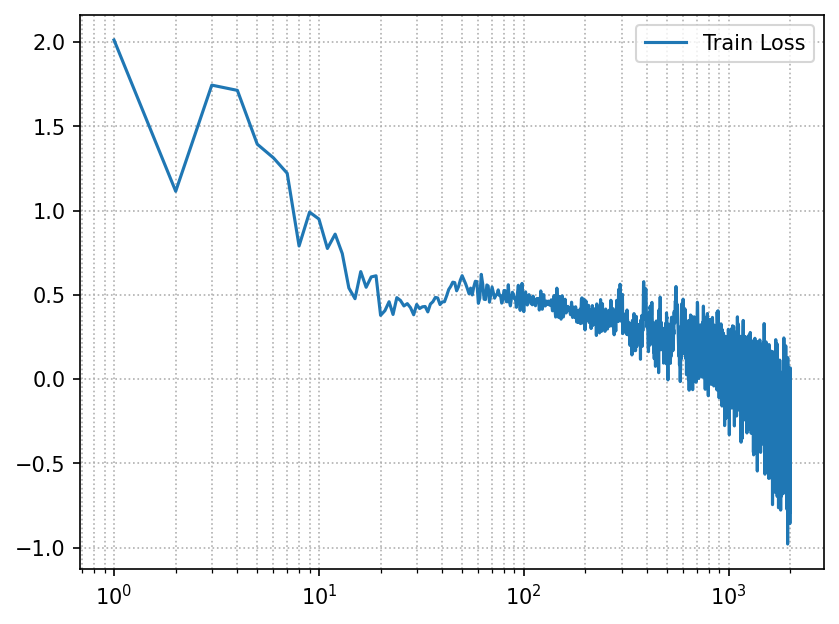

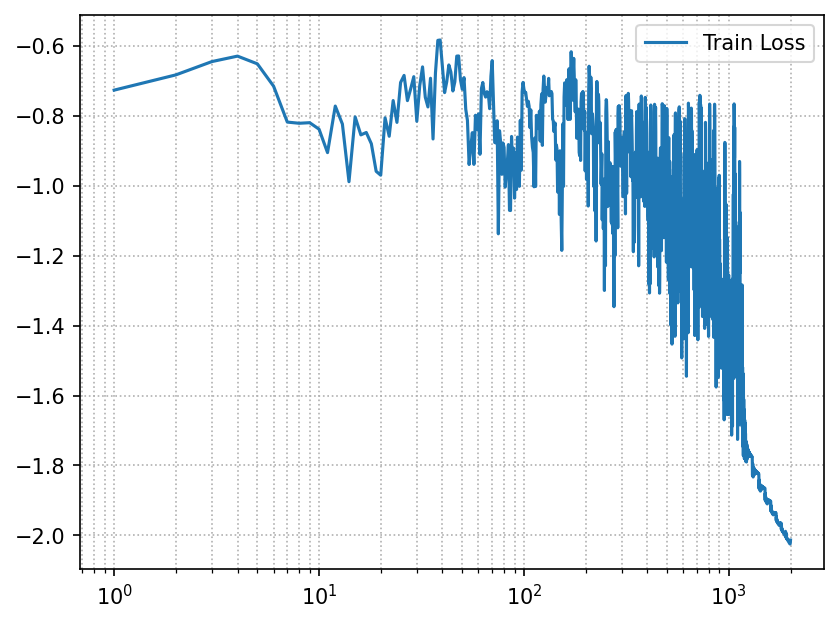

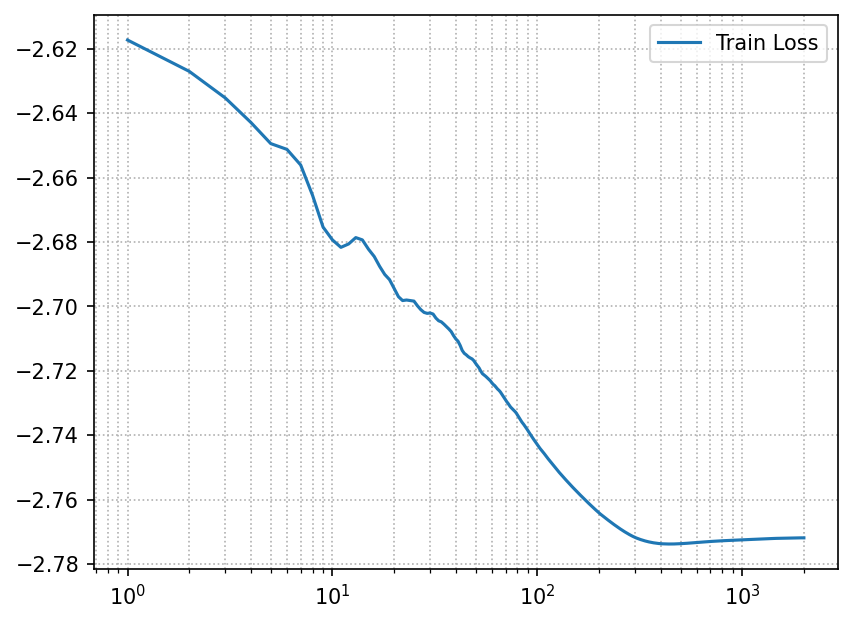

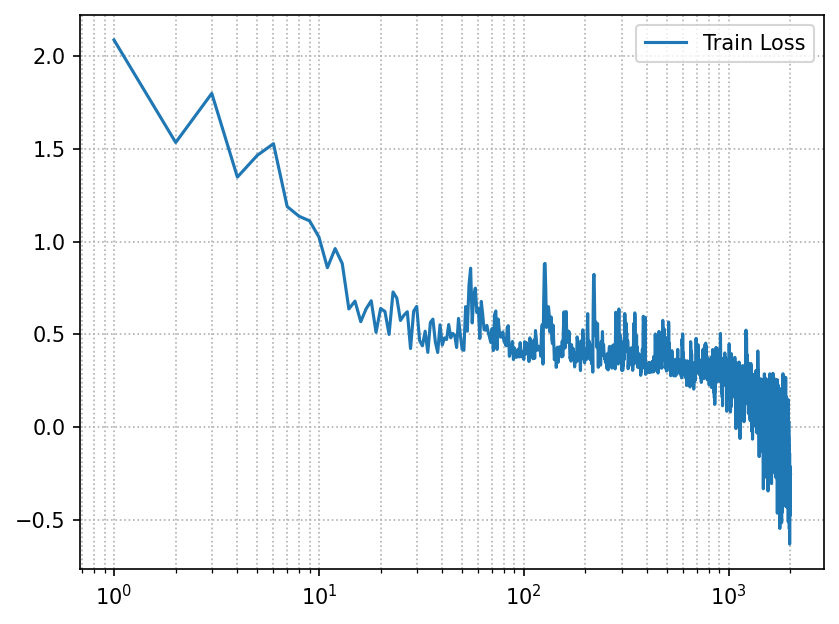

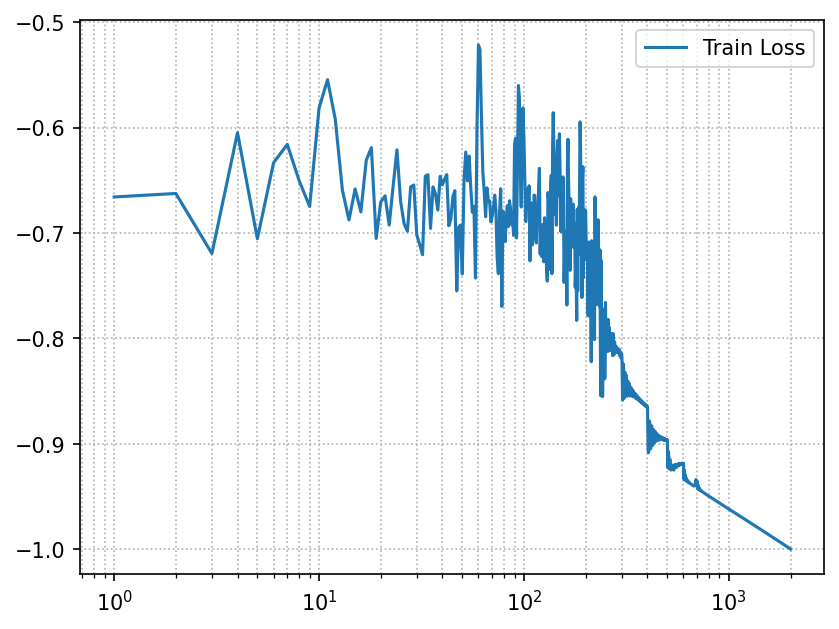

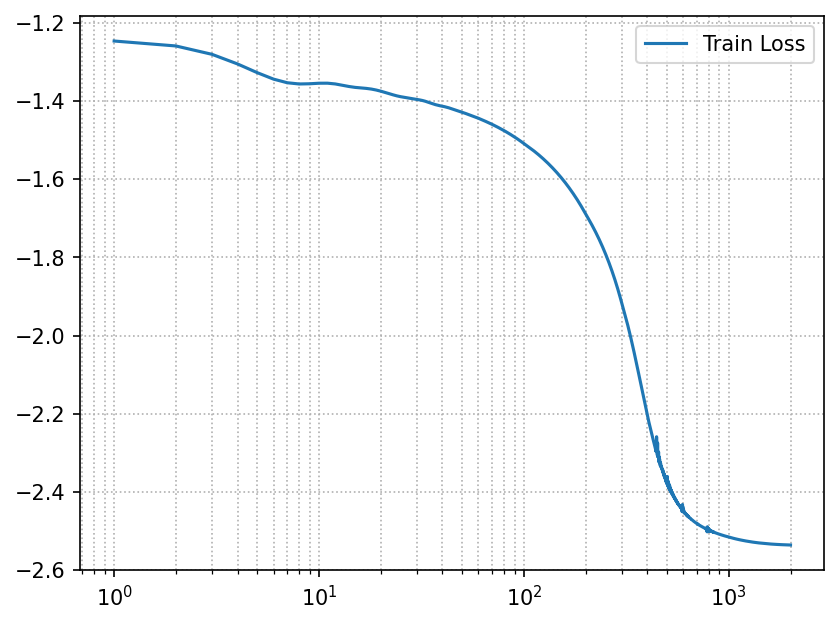

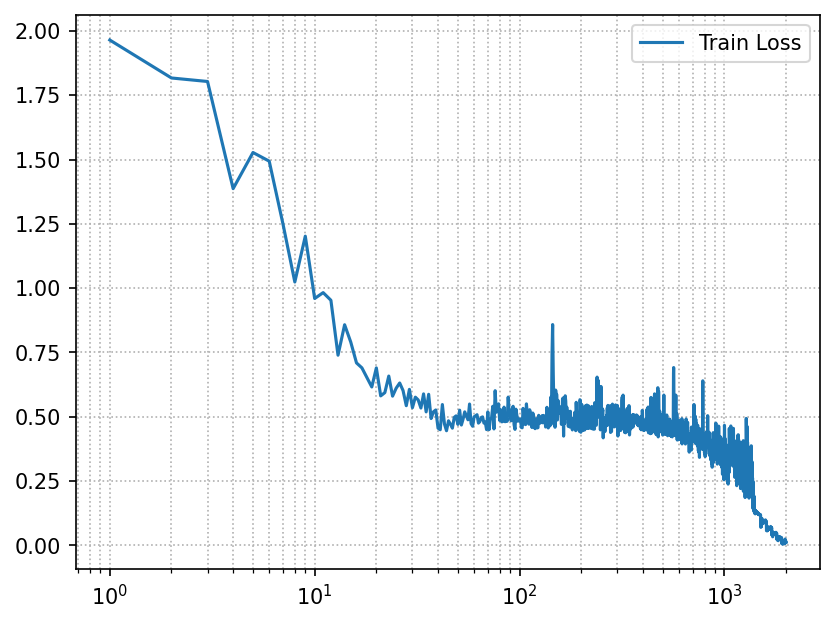

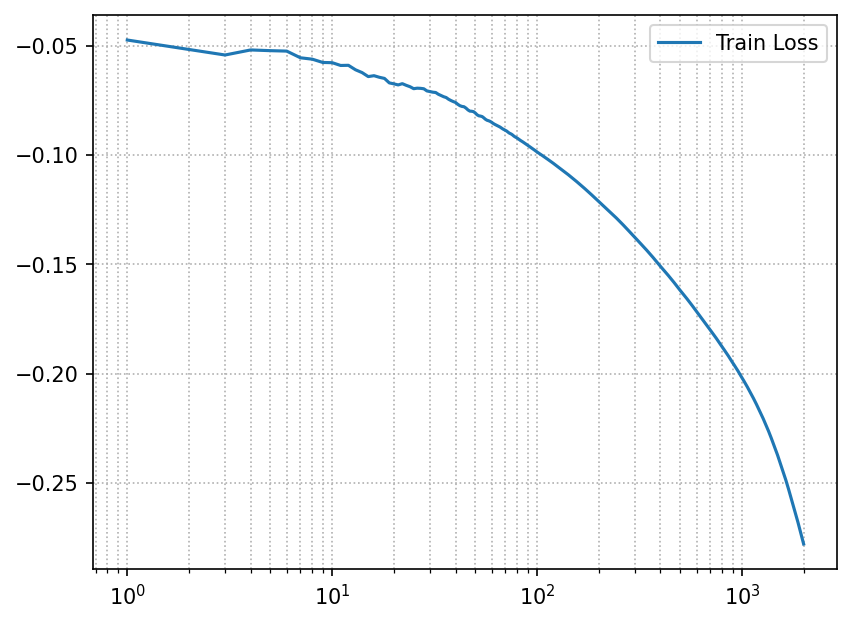

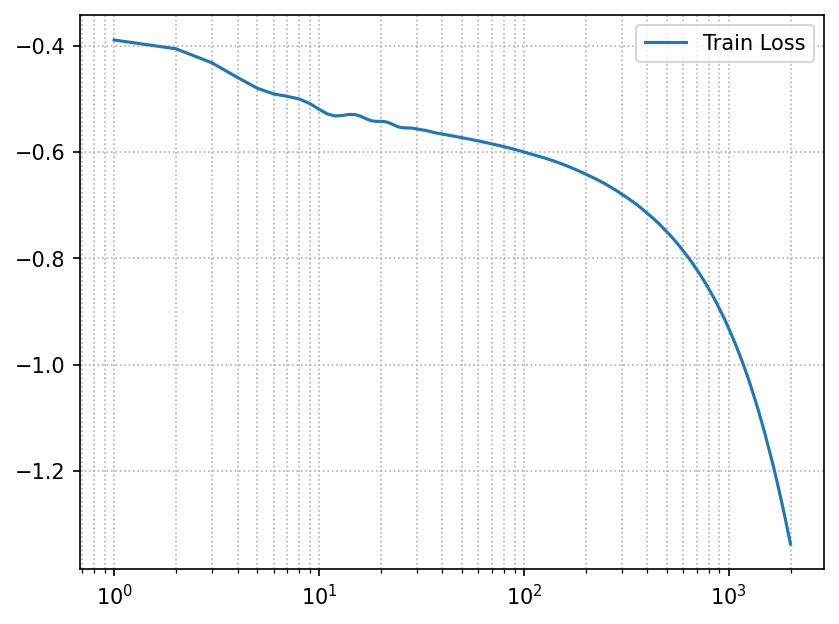

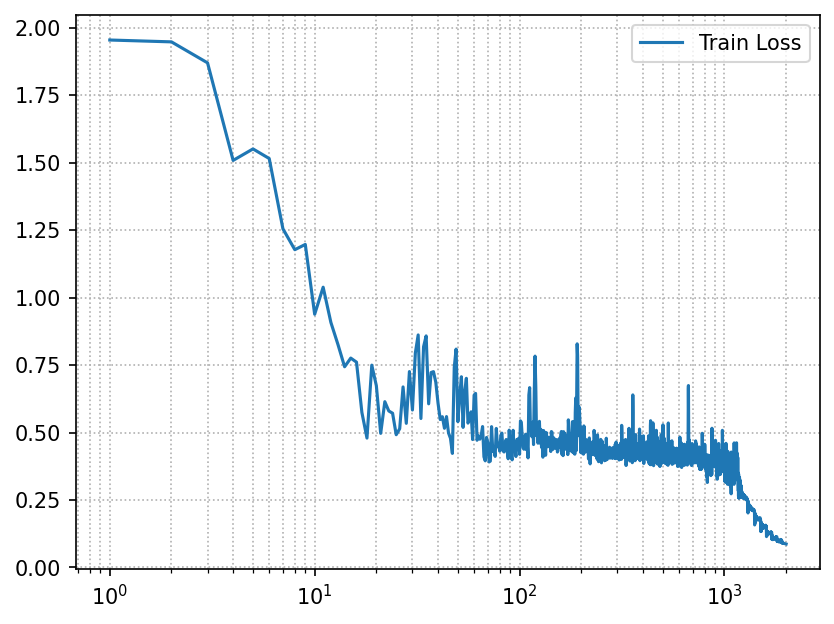

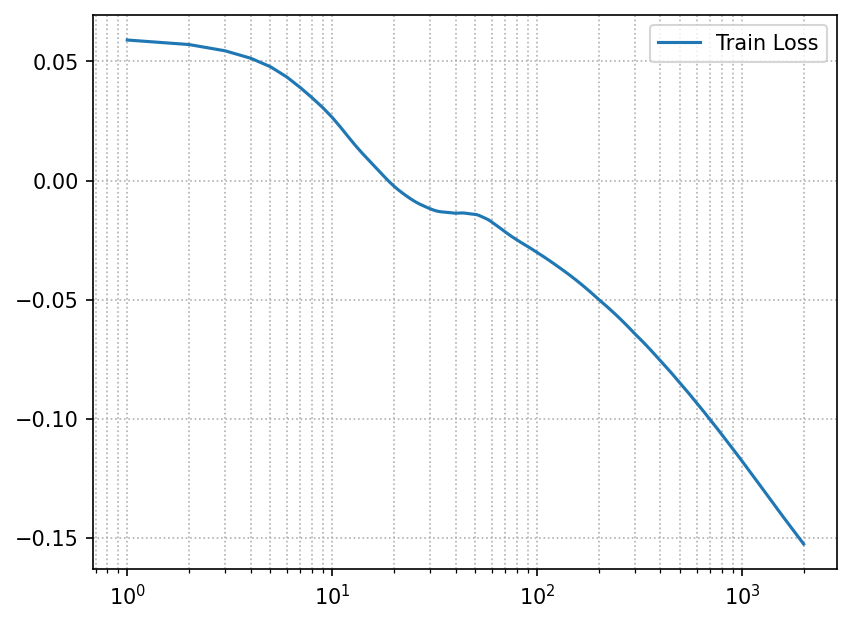

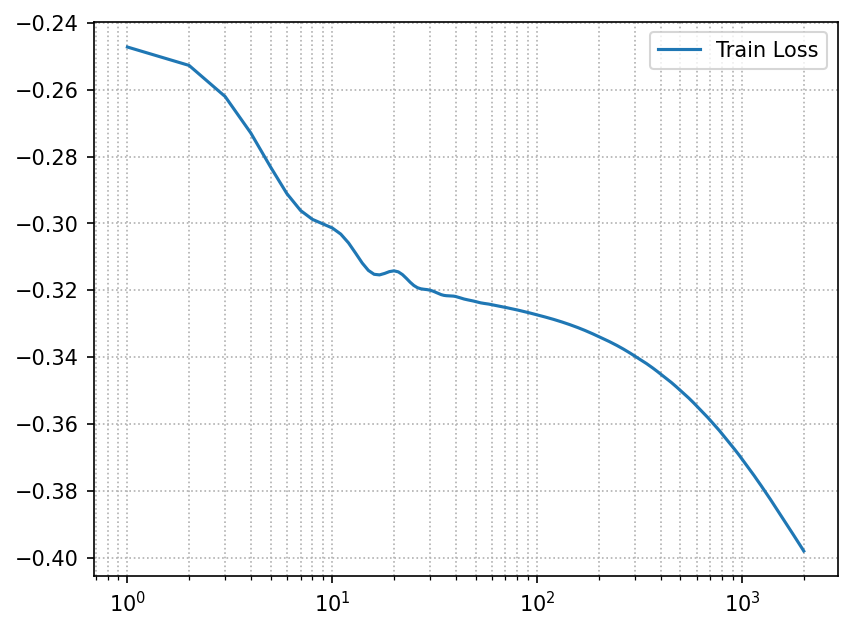

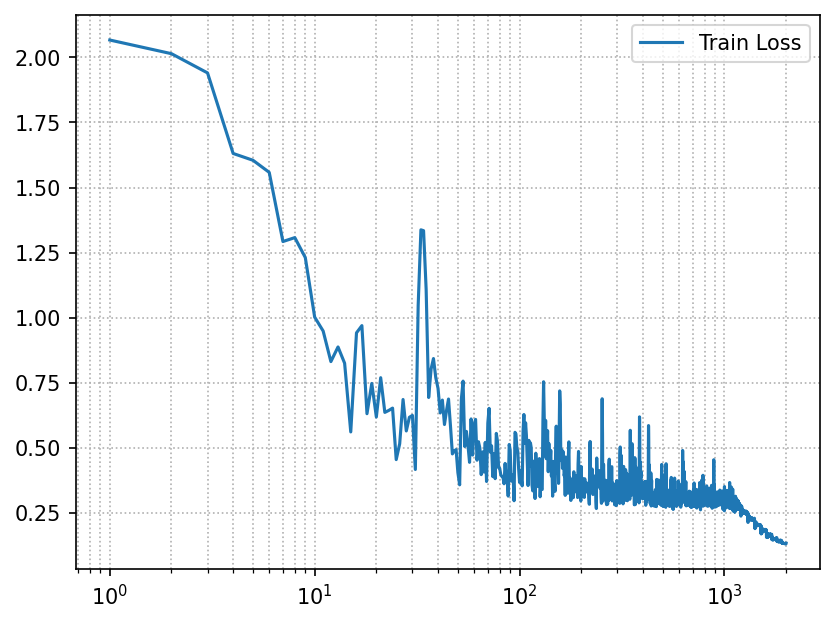

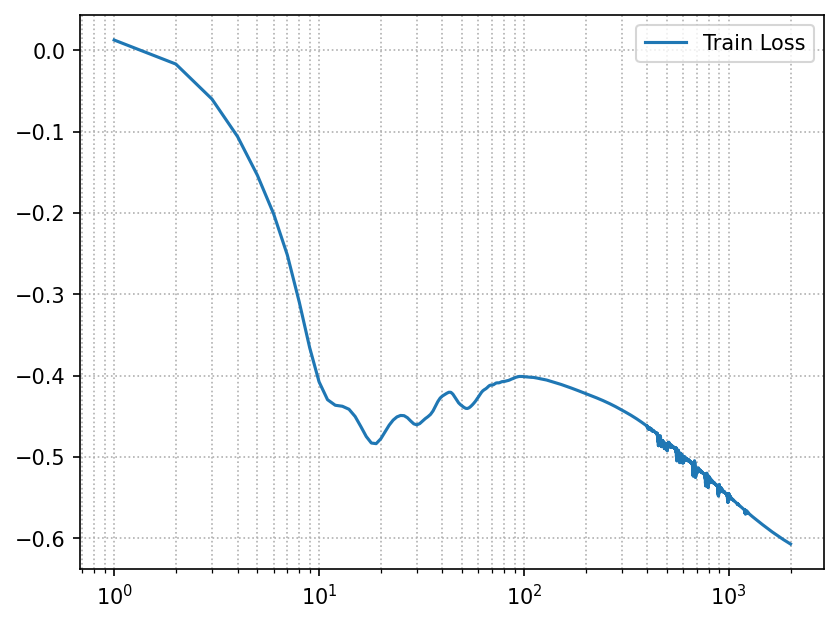

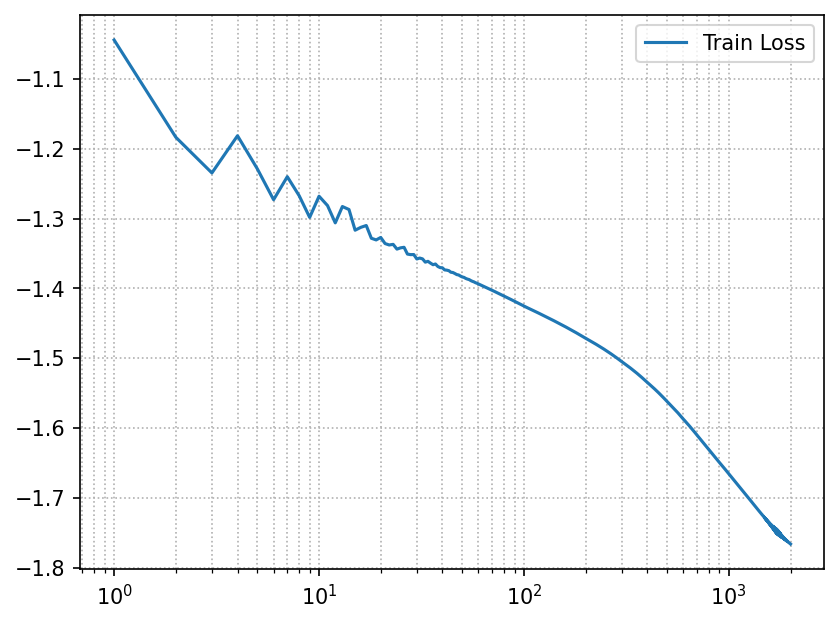

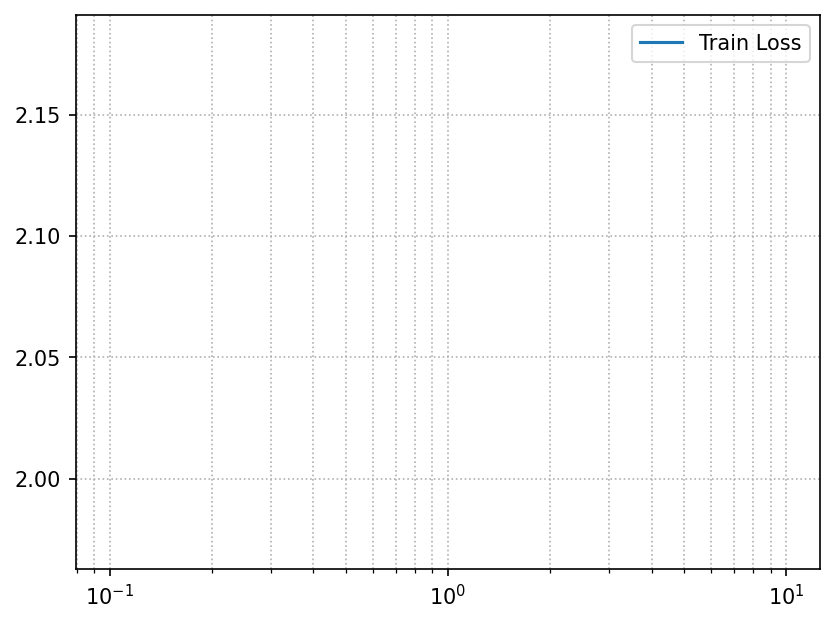

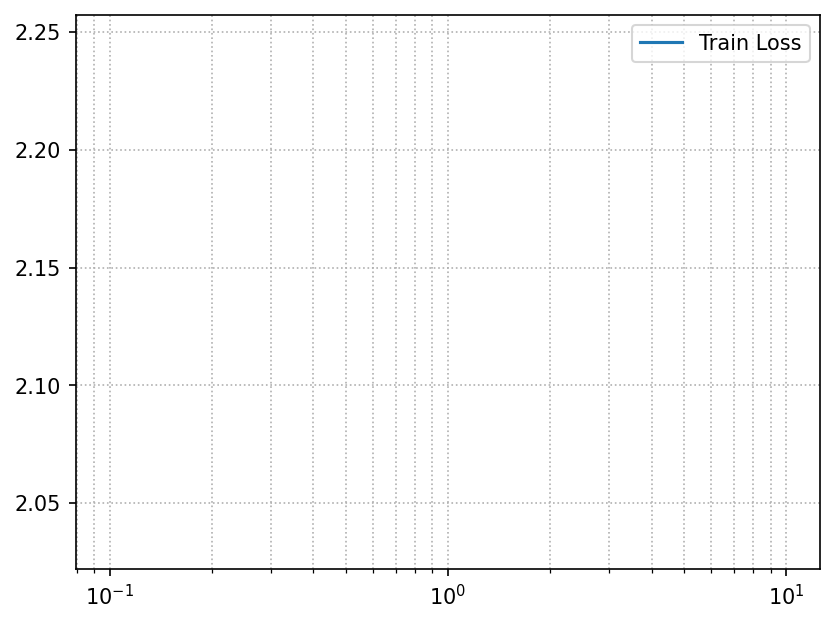

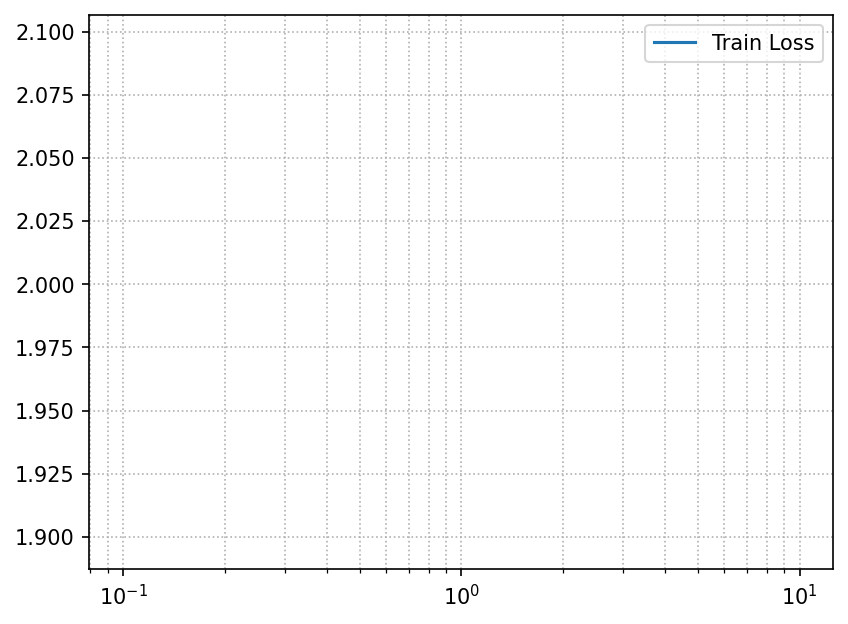

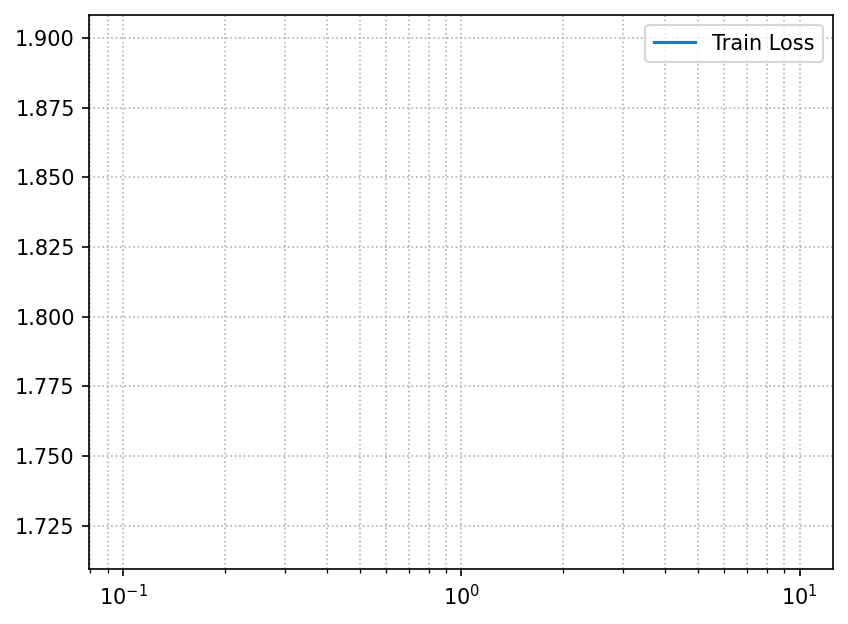

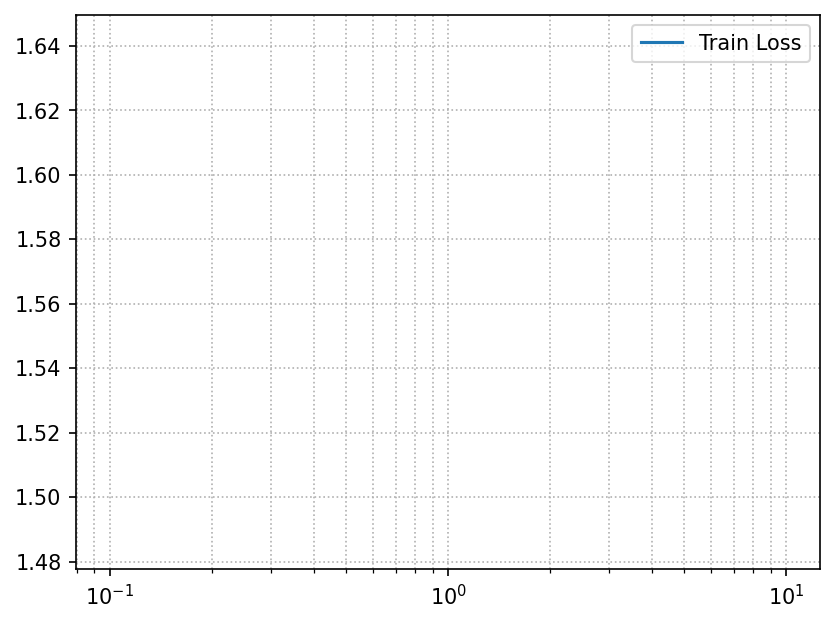

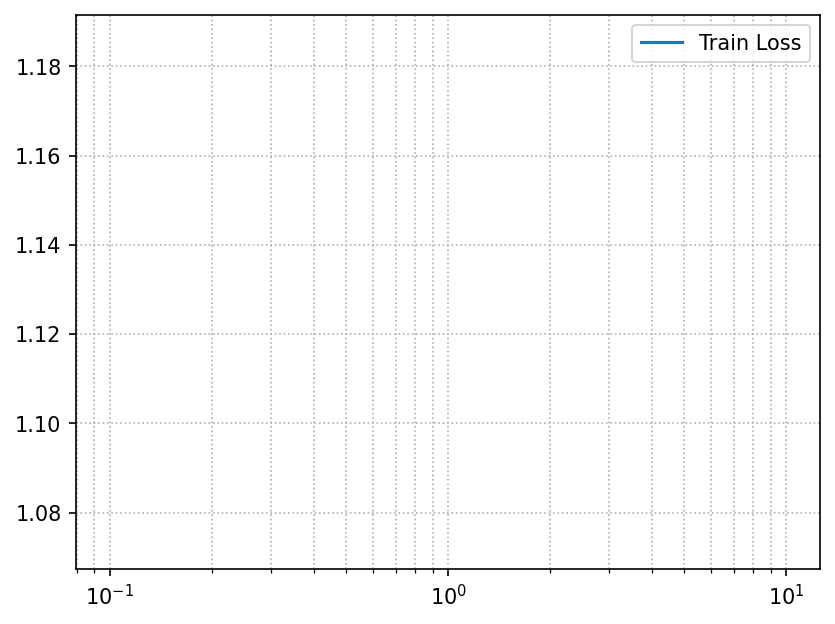

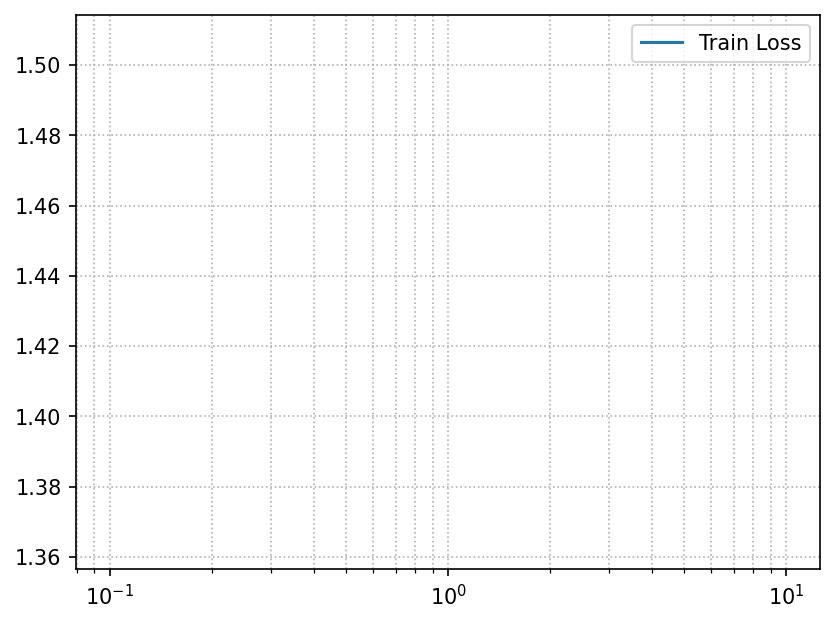

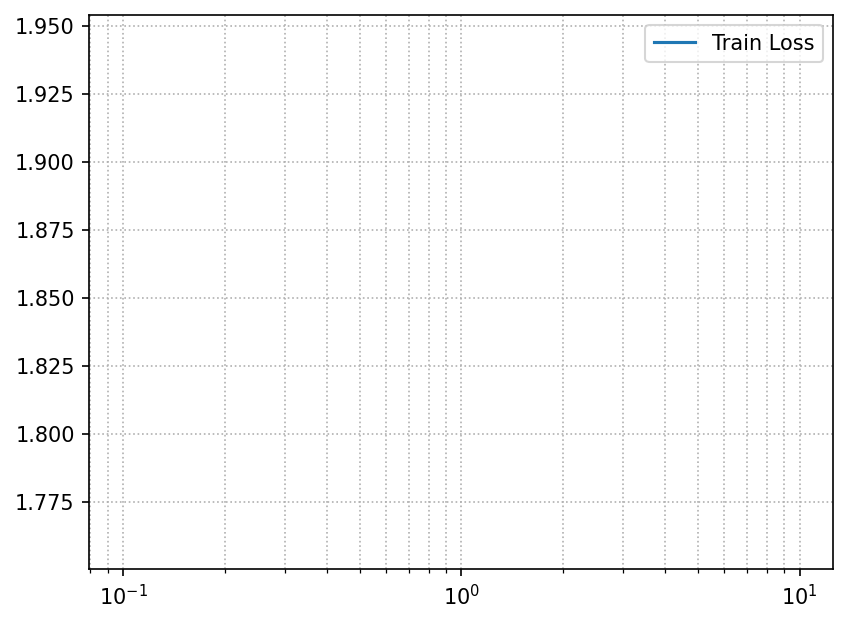

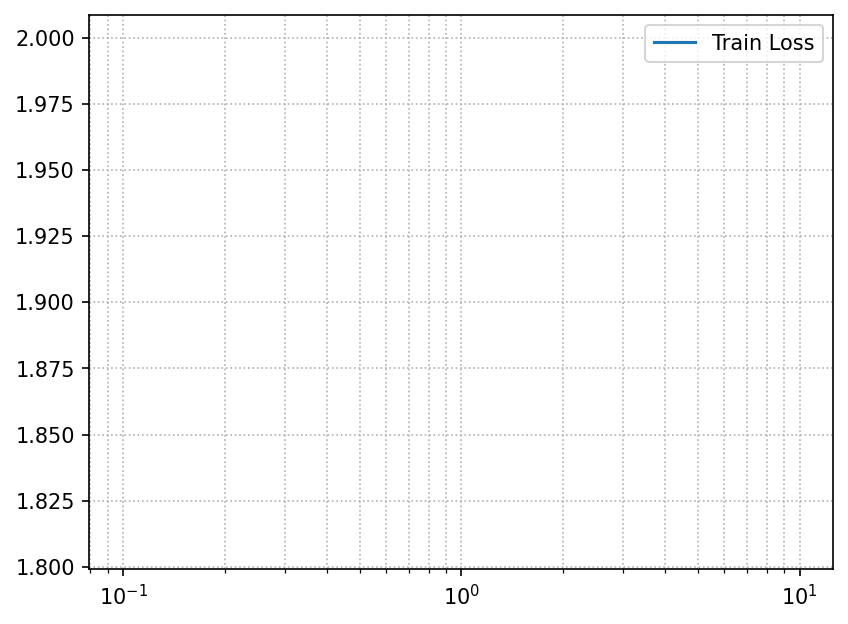

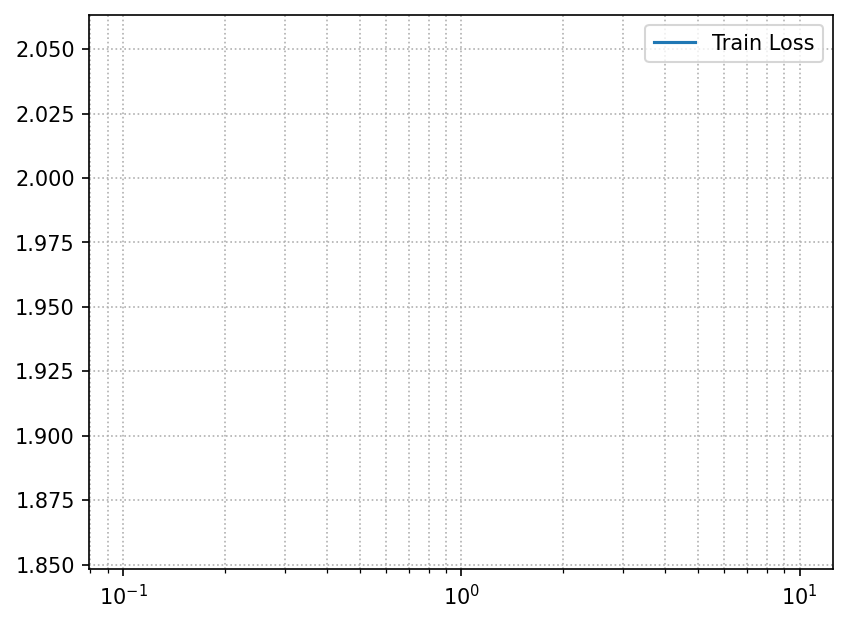

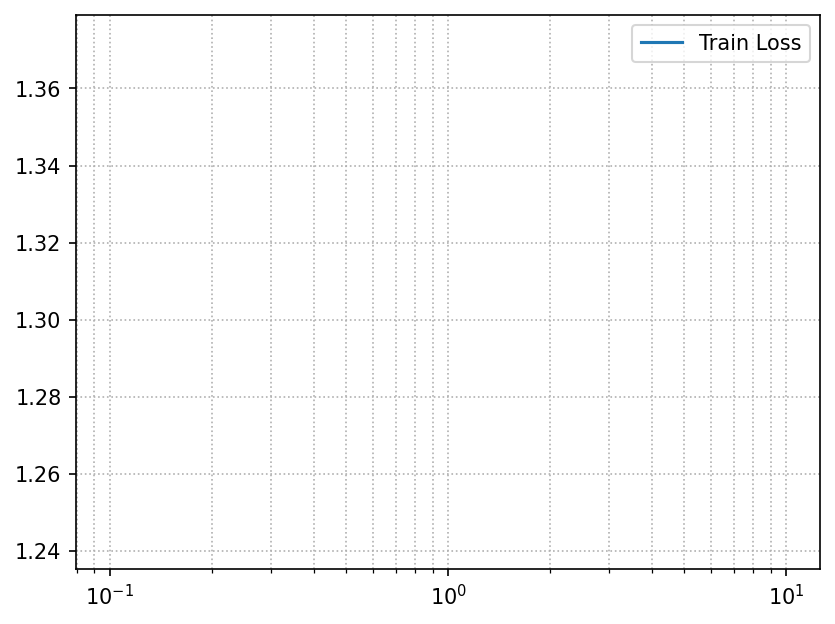

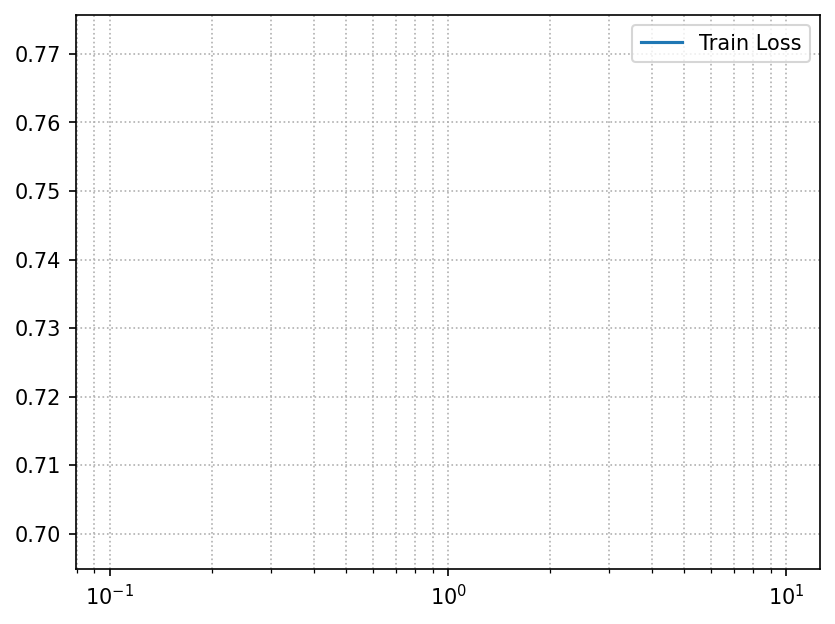

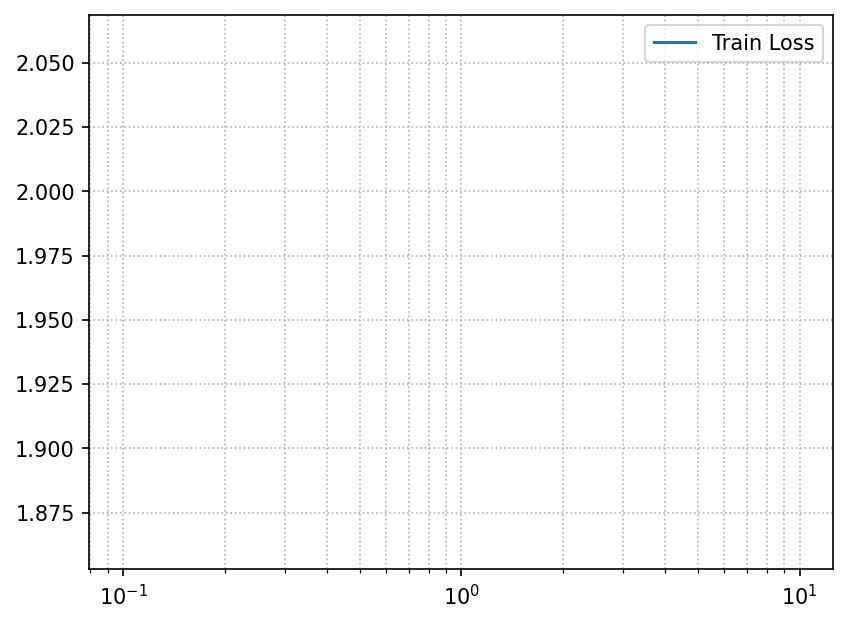

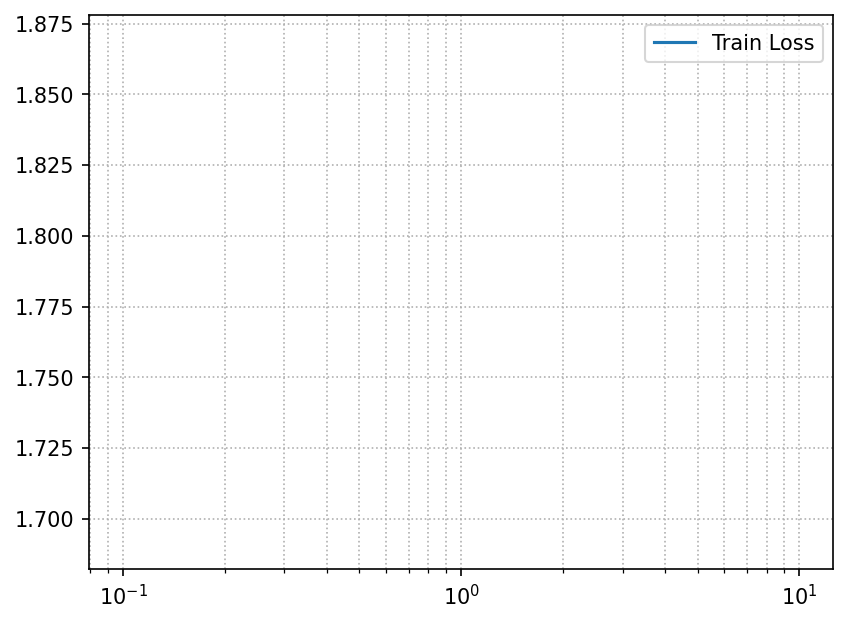

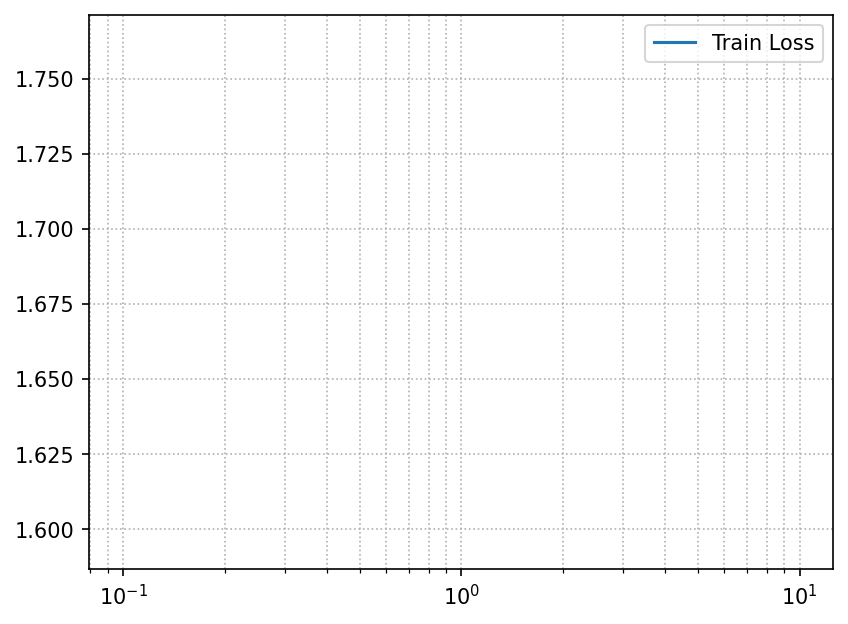

In [6]:
n_epochs = 2000
tol_list = [1e-2, 1e-1, 1e1]
# Marching Steps
N = 10
init_cond = None

# Create Array to Store Plots
final_image = torch.tensor([]).to(device)
final_inputs = torch.tensor([]).to(device)


for i in range(N):
    if i == 5:
        n_epochs = 1
        
    # Initialise Model for New Time Interval
    t_0, t_1 = (1/N) * i, (1/N) * (i+1)    
    model = Pinns_Kuramoto(n_int_t, n_int_x, n_sb, n_tb, t_0, t_1, init_cond)
    
    # Create New Optimizer
    optimizer_ADAM = optim.Adam(model.approximate_solution_flame.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size=100, gamma=0.9)
    
    
    for tols in tol_list:
        model.tol = tols
    
        # Train Time Interval
        hist = model.fit(num_epochs=n_epochs,
                        optimizer=optimizer_ADAM,
                        verbose=True)

        plt.figure(dpi=150)
        plt.grid(True, which="both", ls=":")
        plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
        plt.xscale("log")
        plt.legend()
    
    # Inputs for Plots
    inputs = model.soboleng.draw(50000)
    inputs = model.convert(inputs).to(device)
    
    x_init = torch.linspace(-1, 1, n_tb)
    t_init = torch.full_like(x_init, t_1)
    inp_init = torch.cat((t_init.unsqueeze(1),x_init.unsqueeze(1)), dim=1).to(device)
    init_cond = model.approximate_solution_flame(inp_init)

    output_fluid = model.approximate_solution_flame(inputs.to(device))
    final_inputs = torch.cat((final_inputs, inputs), dim = 0).to(device)
    final_image = torch.cat((final_image, output_fluid), dim = 0).to(device)

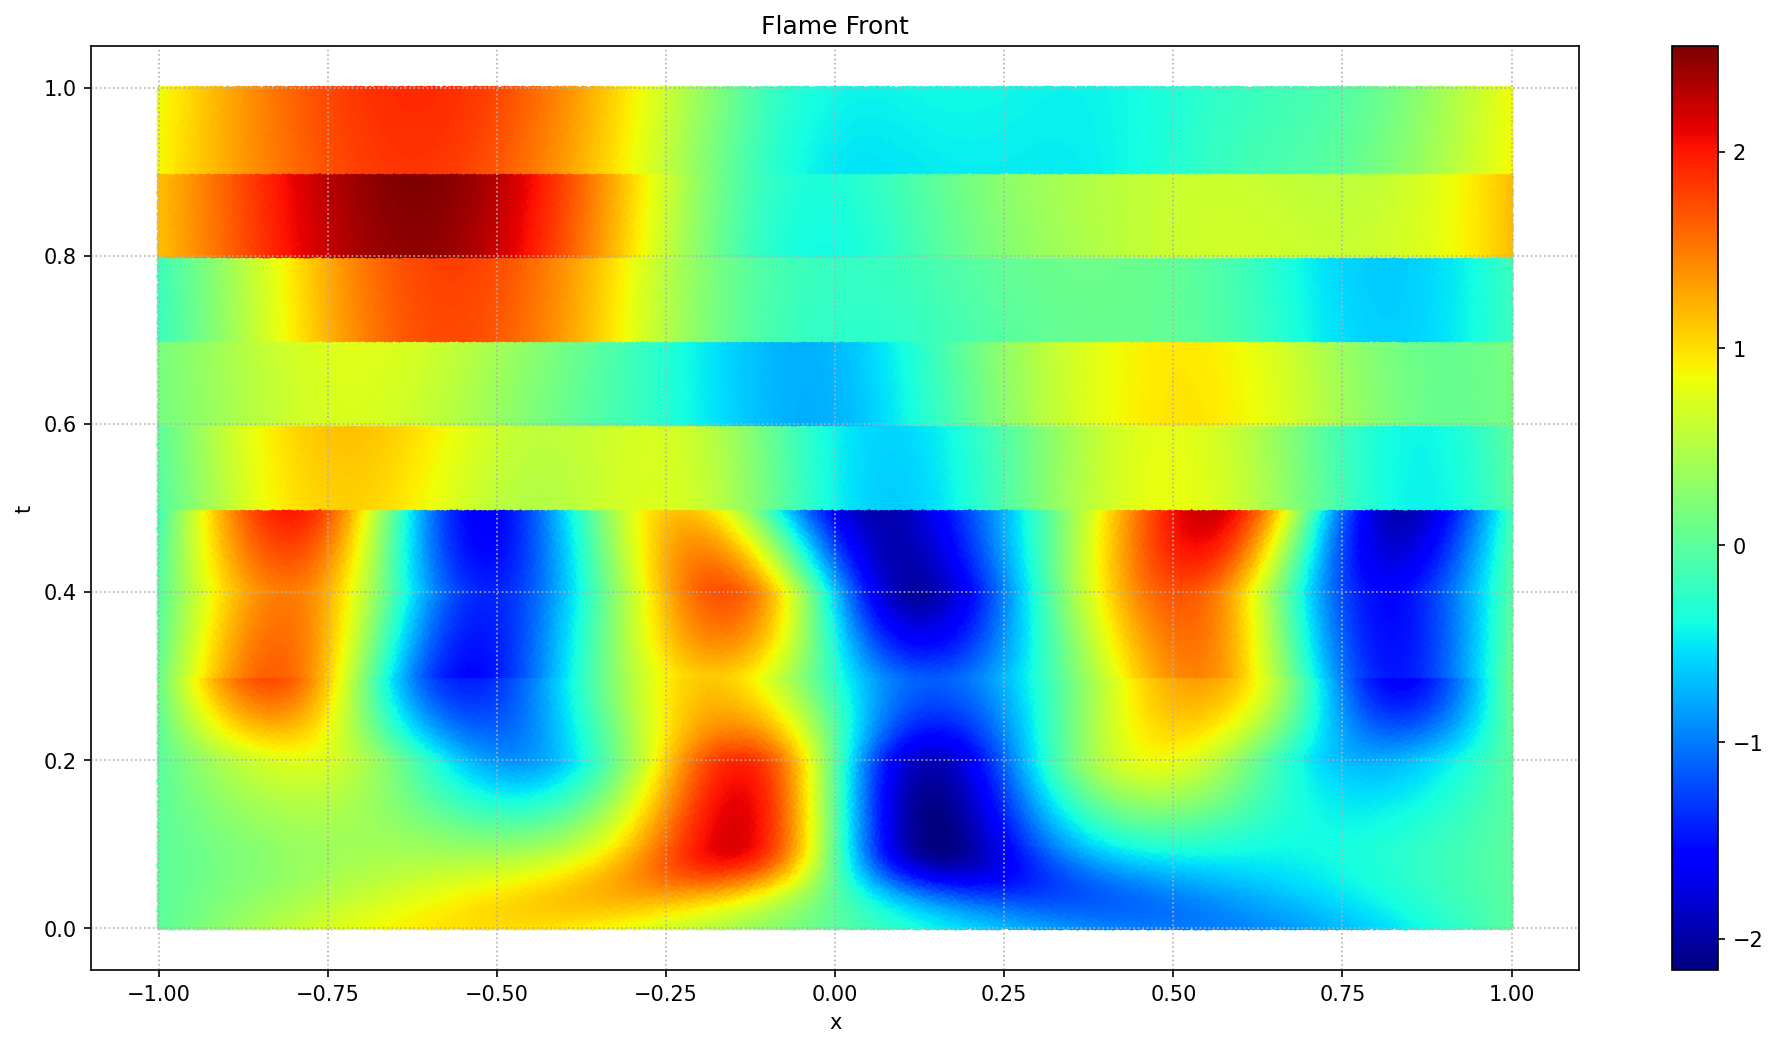

In [7]:
# Plot results with colour
def plotting():
    fig, axs = plt.subplots(1, 1, figsize=(16, 8), dpi=150)
    im1 = axs.scatter(final_inputs[:, 1].cpu().detach(), final_inputs[:, 0].cpu().detach(), c=final_image.cpu().detach(), cmap="jet", s=2)
    axs.set_xlabel("x")
    axs.set_ylabel("t")
    plt.colorbar(im1, ax=axs)
    axs.grid(True, which="both", ls=":")
    axs.set_title("Flame Front")
    plt.show()

plotting()

In [8]:
import pandas as pd 

submission = torch.cat((final_inputs, final_image), dim=1)
submission = pd.DataFrame(submission.cpu().detach().numpy())

# Save the DataFrame as a text file
submission.to_csv(r"C:\Users\matth\Downloads\submission_kuramoto.txt", sep=',', index=False, header=['t', 'x', 'u'])